In [126]:
import nltk
from nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import time
from pickle import Pickler as pck
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

from sklearn.metrics import jaccard_score, accuracy_score, precision_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold, RepeatedKFold, LeaveOneOut, LeavePOut, StratifiedKFold, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

from ClassThread import *
from threading import RLock
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

from scipy.stats import chisquare
from scipy.stats import normaltest, norm, gamma, chisquare, f_oneway, kruskal, spearmanr

#SELECT Id, Score, body, Tags FROM posts WHERE Id > 41670017 and Id <= 45000000 and Score>14 and Tags <> '' and Tags is not null

# Fonction

In [127]:
lemmatizer = WordNetLemmatizer()
stemmer = EnglishStemmer()
tokenizer = nltk.RegexpTokenizer(r'\s', gaps=True)


def multiprocess(func, args):
    '''programmation parallele. 
    permet de réduire le temps
    calcul'''
    with ProcessPoolExecutor(max_workers = 4) as executor:
        res = executor.map(func, args)
    return list(res)


def tokens(text):
    '''tokenize les documents'''
    tokens = tokenizer.tokenize(text)
    return tokens


def tokensLem(text):
    '''tokenize les documents puis les lemmatize'''
    tokens = tokenizer.tokenize(text)
    for j, word in enumerate(tokens):
        tokens[j] = lemmatizer.lemmatize(word)
    return tokens


def tokensStem(text):
    '''tokenize les documents puis les racinise'''
    tokens = tokenizer.tokenize(text)
    for j, word in enumerate(tokens):
        tokens[j] = stemmer.stem(word)
    return tokens


def tokensLemPc(text):
    '''tokenize les documents puis les lemmatize
    avec du pos tagging'''
    tokens = tokenizer.tokenize(text)
    tag = nltk.pos_tag(tokens)
    for j, word in enumerate(tokens):    
        if tag[j][1][0] == 'J':
            tokens[j] = lemmatizer.lemmatize(word, 'a')
        elif tag[j][1][0] == 'V':
            tokens[j] = lemmatizer.lemmatize(word, 'v')
        elif tag[j][1][0] == 'N':
            tokens[j] = lemmatizer.lemmatize(word, 'n')
        elif tag[j][1][0] == 'R':
            tokens[j] = lemmatizer.lemmatize(word, 'r')
        else:
            tokens[j] = lemmatizer.lemmatize(word) 
    return tokens


def splitFreq(freq, kSplit):
    '''split la liste'''
    splitListe = np.array_split(np.array(freq), kSplit)
    return splitListe


def sumCount(liste):
    '''somme des objet nltk.Counter'''
    count = nltk.Counter()
    for v in liste:
        count += v
    return count


def freq_Sort(listOfList):
    freq = multiprocess(nltk.Counter, listOfList)

    # On fait des "Sommes" de compteur successive
    # qu'on renvoie dans une liste et ainsi de suite.
    # On obtient un seul compteur: les # Tags.
    for k in [1000, 100, 10, 1]:
        l = splitFreq(freq, k)
        freq = multiprocess(sumCount, l)

    # On ordone le vocabulaire de Tags
    return sorted(freq[0].items(), key = lambda x: x[1], reverse = True)

# Récupération des données dans un DataFrame

In [128]:
# select Id, Score, ViewCount, Body, Tags, AnswerCount, CommentCount, FavoriteCount from posts where id > 514205 and id <= 600000
Ti = time.time()

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 200000)

df = pd.DataFrame()
for i in range(1, 9):
    table = pd.read_csv('df/df'+str(i)+'.csv', sep = ',')
    if df.empty:
        df = table
    else:
        df = pd.concat([df, table], ignore_index = True)
        
df.shape

(397170, 4)

### toutes les données ont été préfiltrées Lors des requetes SQL. On ne garde que les lignes dont le Score et superieur a la moyenne de la colonne Score

In [129]:
df.head()

,Id,Score,body,Tags
0,1000002,97,"<p>What is <code>SEGV_MAPERR</code>, why does ...",<linux><posix><segmentation-fault><coredump>
1,1000023,30,<p>When should I go for a Windows Service and ...,<c#><windows><winforms><windows-services>
2,1000040,250,<p>How can I retrieve the item that is selecte...,<c#><wpf><mvvm><treeview><selecteditem>
3,1000046,16,<p>I'm a two-week old infant with regards to E...,<json><erlang>
4,1000101,18,<p>Please tell me the basic difference between...,<.net><comparison>


In [130]:
# Info sur la table réalisée
print(df.info())
print('\n','tx remplissage\n',df.count()/df.shape[0])
print('\n',df['Score'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397170 entries, 0 to 397169
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      397170 non-null  int64 
 1   Score   397170 non-null  int64 
 2   body    397170 non-null  object
 3   Tags    397170 non-null  object
dtypes: int64(2), object(2)
memory usage: 12.1+ MB
None

 tx remplissage
 Id       1.0
Score    1.0
body     1.0
Tags     1.0
dtype: float64

 count    397170.000000
mean         52.158693
std         126.644727
min          15.000000
25%          19.000000
50%          26.000000
75%          47.000000
max       25596.000000
Name: Score, dtype: float64


# Extraction des tags associés aux documents

In [131]:
# On extrait les Tags avec des Regex puis 
# on transsforme la chaine de caractère en une 
# une liste de mots avec 'Split'
df['Tags'] = df['Tags'].str.replace(r'>', '', regex=True)
df['Tags'] = df['Tags'].str.replace(r'^<', '', regex=True)
df['Tags'] = df['Tags'].str.replace(r'<', ' ', regex=True)

# En minuscule
df['Tags'] = df['Tags'].str.lower()
tagList = df['Tags'].values.tolist()

In [132]:
# On compte le nombre d'apparition de nos Tag
maxTag = 60
vectTag = CountVectorizer(max_features=maxTag, tokenizer=tokens)
vectTag.fit(tagList)
X = vectTag.transform(tagList)
count = X.toarray().sum(axis=0)

# On récupère les Tags
tag = vectTag.get_feature_names()

# On crée un dictionnaire des Tags avec leur fréquence
# d'apparition, trier par ordre décroissant
dictTag = {}

for i, v in zip(tag, count):
    dictTag[i] = v

# on trie par freéquence décroissante
dictTag = sorted(dictTag.items(), key=lambda colonnes: colonnes[1], reverse=True)
dictTag = dict(dictTag)

/home/sylvain/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [133]:
dictTag

{'python': 35406,
 'java': 35178,
 'javascript': 34407,
 'android': 30589,
 'c#': 29560,
 'c++': 19197,
 'ios': 15303,
 'html': 14337,
 'php': 13855,
 'jquery': 12060,
 'css': 11805,
 '.net': 10154,
 'git': 8042,
 'c': 7870,
 'node.js': 7605,
 'sql': 6984,
 'objective-c': 6853,
 'r': 6736,
 'ruby-on-rails': 6595,
 'mysql': 6553,
 'swift': 6267,
 'iphone': 6049,
 'ruby': 5540,
 'linux': 5445,
 'django': 5193,
 'arrays': 5132,
 'string': 4968,
 'xcode': 4803,
 'angular': 4785,
 'asp.net': 4655,
 'json': 4644,
 'angularjs': 4583,
 'reactjs': 4372,
 'sql-server': 4200,
 'asp.net-mvc': 3957,
 'bash': 3927,
 'spring': 3817,
 'c++11': 3611,
 'eclipse': 3500,
 'regex': 3474,
 'performance': 3430,
 'windows': 3395,
 'typescript': 3361,
 'macos': 3355,
 'scala': 3304,
 'visual-studio': 3288,
 'pandas': 3269,
 'postgresql': 3064,
 'algorithm': 2945,
 'unit-testing': 2933,
 'multithreading': 2929,
 'wpf': 2841,
 'docker': 2811,
 'python-3.x': 2649,
 'android-studio': 2579,
 'database': 2546,
 'mon

### On constate que le nombre moyen de tag par document est de 3 en moyenne. Par la suite on propsoera donc 3 Tags

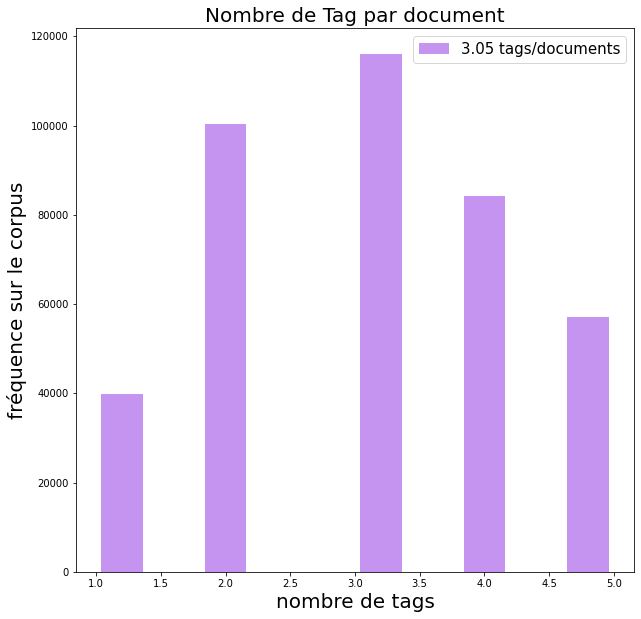

On compte en moyenne 3.05 tags par documents


In [134]:
# On transforme les chaines de caratere en liste de mots
liste = df['Tags'].str.split(' ').tolist()

# On compte le nombre moyen de Tag
# par échantillon
size = []
for i in liste:
    size.append(len(i))
    
# Moyenne de tag par document
mean=sum(size)/len(size)

plt.figure(figsize=(10, 10))
plt.hist(size, color='blueviolet', alpha=0.5, histtype='barstacked', rwidth=0.8, label="{0:.2f} tags/documents".format(mean))
plt.xlabel('nombre de tags', fontsize=20)
plt.ylabel('fréquence sur le corpus', fontsize=20)
plt.title('Nombre de Tag par document', fontsize=20)
plt.legend(fontsize=15)
plt.show()
    
print("On compte en moyenne {0:.2f} tags par documents".format(mean))

### Frequence de chaque Tag parmis l'ensemble des Tags (du corpus Tags)

### On ne conserve que les 60 premiers Tags les plus fréquent (temps de calcul risque d'etre trop)

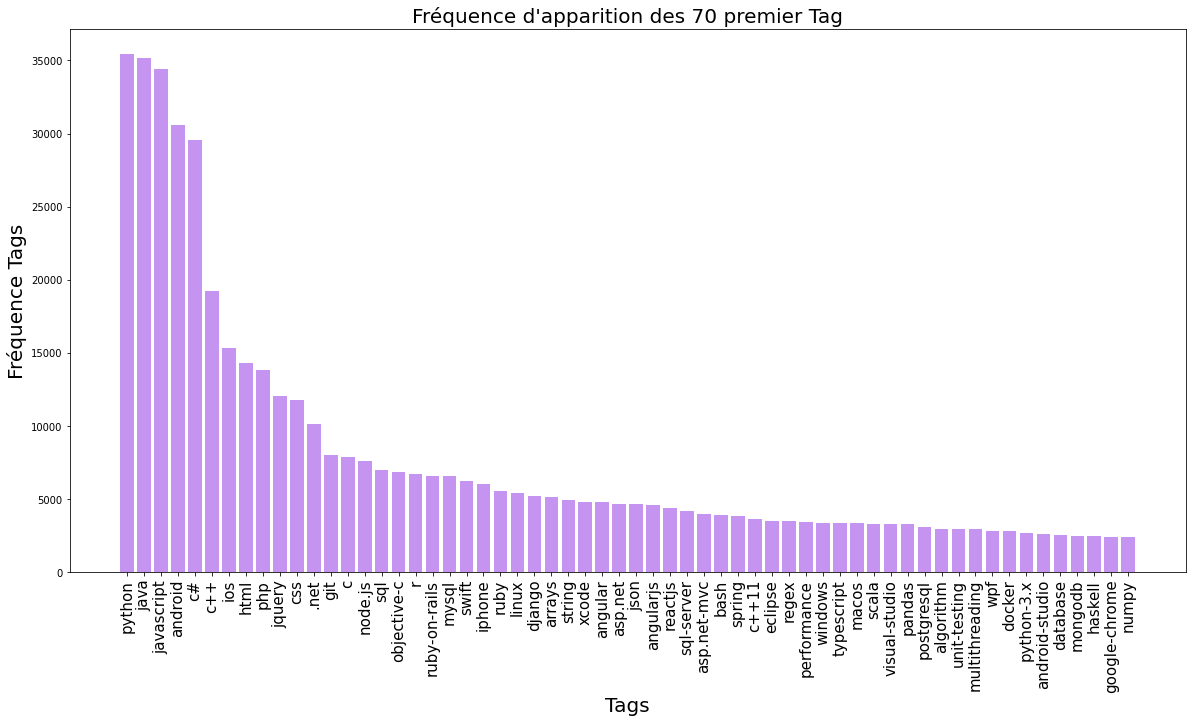

In [135]:
# limit de selection des tags
limit = maxTag

#pour l'affichage
x = list(dictTag.keys())[0: 70]
y = list(dictTag.values())[0: 70]

# Affichage
plt.figure(figsize=(20, 10))   
plt.bar(x, y, color='blueviolet', alpha=0.5)
plt.xlabel("Tags", fontsize=20)
plt.xticks(rotation='vertical', fontsize=15)
plt.ylabel("Fréquence Tags", fontsize=20)
plt.xticks(fontsize=15)
#plt.axvline(x=limit-1, linestyle=':', color='dodgerblue', linewidth=3, label="limit")
plt.title("Fréquence d'apparition des 70 premier Tag",  fontsize=20)
#plt.legend(fontsize=20)
plt.show()

In [136]:
final = []
taglist = list(dictTag.keys())

for i, v in enumerate(liste):
    if set(v).issubset(taglist):
        final.append(set(v))
    else:
        final.append(np.nan)

In [137]:
# Visualisation des données Tags transformées
df['Tags'] = pd.Series(data=final, index=df.index)
df[['body', 'Tags']].head()

,body,Tags
0,"<p>What is <code>SEGV_MAPERR</code>, why does ...",NaN
1,<p>When should I go for a Windows Service and ...,NaN
2,<p>How can I retrieve the item that is selecte...,NaN
3,<p>I'm a two-week old infant with regards to E...,NaN
4,<p>Please tell me the basic difference between...,NaN


### On supprime les  NA

In [138]:
# On supprime tous les NA générés
df = df.dropna()
df.shape

(44503, 4)

In [139]:
df[['body', 'Tags']].head(100)

,body,Tags
20,<p>In the start page in VS2008 or any version ...,"{c#, visual-studio, .net}"
21,<p>It is a question about the appointment of l...,{css}
27,<p>I'm trying to convert <code>std::string</co...,{c++}
35,<p>I am needing to detect when a user is inact...,"{jquery, javascript}"
40,<p>I want to load a MYSQL-database into the RA...,{mysql}
59,<p>I have a bunch of assignment operations in ...,"{regex, visual-studio}"
61,<p>I have a text field that allows a user to e...,{javascript}
79,<p>I was reading a tutorial and the author men...,"{javascript, html}"
85,<p>I have an array of strings that are valid j...,"{jquery, javascript}"
93,<p>I am tracking a project with git. There are...,{git}


In [140]:
df.count()/df.shape[0]

Id       1.0
Score    1.0
body     1.0
Tags     1.0
dtype: float64

# Extraction du texte des documents

### On extrait au maximum le texte du formalisme HTML

### Traitement du texte pour la colonne 'body'

In [141]:
# supprime les balise
for i in range(df.shape[0]):
    soup = BeautifulSoup( df['body'].iloc[i], 'html.parser')
    df['body'].iloc[i] = soup.get_text()

# en minuscule
df['body'] = df['body'].str.lower()  

# suprime tout ce qui n'est pas du texte
# exception de language de programmation ou autre termes
# contenant ds caractère spéciaux: c++ / node.js etc
# préserve les nom contenat de trait d'union etc..
# la liste de ces termes présent dans la regex n'est pas exhaustive.
df['body'] = df['body'].str.replace(r'[^a-z\+\#\.\-]', ' ', regex = True)  
df['body'] = df['body'].str.replace(r'([^c]\+{2,})| \++|\w+\++\w+', ' ', regex = True) 
df['body'] = df['body'].str.replace(r'[^a-z]\-{1,}|\-{1,}[^a-z]', ' ', regex = True)
df['body'] = df['body'].str.replace(r'[^a-z+]\.{1,}|\.{1,}[^a-z]', ' ', regex = True)
df['body'] = df['body'].str.replace(r'([^c]\#{1,})| \#+|\w+\#+\w+', ' ', regex = True)
df['body'] = df['body'].str.replace(r'[\.]+\w{3,}', ' ', regex = True)
df['body'] = df['body'].str.replace(r'[\-]+\w{7,}', ' ', regex = True)


# Supprime les mots > 30 lettres
df['body'] = df['body'].str.replace(r'\w{30,}', ' ', regex = True)

/home/sylvain/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [142]:
# On supprime les verbe les adverb adjectif pronoms, et autres ...
meaning = ['NN', 'NNS', 'JJ']
trans = []
for i, doc in enumerate(df['body'].tolist()):
    listDoc = []
    token = tokenizer.tokenize(doc)
    for tok in token:
        if nltk.pos_tag([tok])[0][1] in meaning:
            listDoc.append(lemmatizer.lemmatize(tok))
    if len(listDoc) == 0:
        trans.append(" ".join(token))
    else:
        trans.append(" ".join(listDoc))
        
df['body'] = pd.Series(data=trans, index=df.index)

In [165]:
lemmatizer.lemmatize('sklearn')

'sklearn'

# DataLeakage => on split les datas en train et test set

In [143]:
X = df['body'].to_numpy().reshape(-1, 1)

# Pour y on binarize la sortie
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Tags'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# corpus va être traité par la suite
# uniquement pour trouver les Stop Word de nos
# documents
# On conserve les documents présents dans corpusTrain
# et corpusTest pour la partie supervisée.
# La partie non surpervisée ce fera sur la partie Train
# également.
corpus = corpusTrain = X_train.reshape(1, -1).tolist()[0]
corpusTest = X_test.reshape(1, -1).tolist()[0]

In [144]:
# On récupère les tags
Tag = mlb.classes_

## On cherche les StopWord sur le Train set pour les documents

### On tokenize le corpus Train

In [145]:
# On tokenize le corpus avec la fonction choisi
# la foncton multiprocess permet d'utiliser tout les
# processeur
T1 = time.time()
corpus = multiprocess(tokens, corpus)
T2 = time.time()
print(T2- T1)

9.444985389709473


### Fréquence des mots dans le corpus (colonne 'body')

In [146]:
# On calcul la fréquence d'appariation de chaque mot.
# la foncton multiprocess dans freq_sort permet d'utiliser tout les
# processeur
freqSort = freq_Sort(corpus)
freqSort

[('i', 128645),
 ('t', 19276),
 ('s', 15848),
 ('class', 15384),
 ('string', 14599),
 ('file', 14478),
 ('function', 14474),
 ('m', 14239),
 ('div', 13221),
 ('value', 12721),
 ('code', 12408),
 ('error', 11996),
 ('name', 11935),
 ('id', 11470),
 ('want', 11402),
 ('return', 10511),
 ('new', 10029),
 ('android', 9978),
 ('way', 9558),
 ('use', 9539),
 ('type', 9196),
 ('x', 9061),
 ('c', 9037),
 ('b', 8820),
 ('array', 8739),
 ('data', 8703),
 ('int', 8175),
 ('var', 7931),
 ('work', 7827),
 ('user', 7477),
 ('object', 7448),
 ('d', 7297),
 ('text', 6992),
 ('example', 6756),
 ('need', 6592),
 ('method', 6310),
 ('list', 5981),
 ('e', 5960),
 ('line', 5817),
 ('http', 5744),
 ('public', 5645),
 ('test', 5560),
 ('app', 5387),
 ('time', 5346),
 ('something', 5341),
 ('import', 5276),
 ('input', 5199),
 ('true', 5177),
 ('px', 5096),
 ('table', 5093),
 ('set', 5085),
 ('element', 5018),
 ('f', 4980),
 ('html', 4857),
 ('number', 4797),
 ('n', 4644),
 ('question', 4603),
 ('same', 4508),

### Document frequency de chaque mot du vocabulaire pour la colonne 'Body'

In [147]:
# On compte le nombre de document dans lesquels 
# chaque mot de notre vocabulaire apparaissent.
# Affichage seulement les 20 premiers
docFreq = []
for word in freqSort[0: 1000]:
    count = 0
    for i, v in enumerate(corpusTrain):
        if word[0] in v:
            count += 1
    docFreq.append(count/len(corpusTrain))

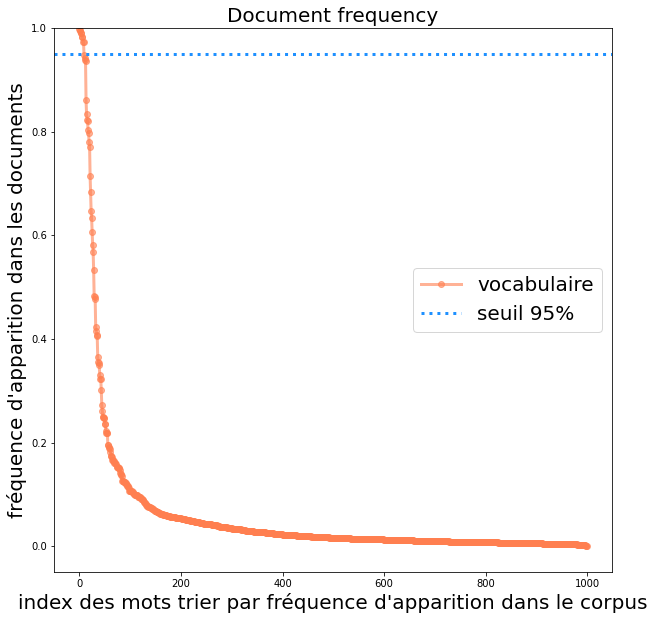

In [148]:
# Affichage document frequency.
# On constate que les mots le plus fréquents 
# est présent dans ~90% des documents
docFreqSort = sorted(docFreq, reverse=True)
x = range(len(docFreqSort))
plt.figure(figsize=(10, 10))
plt.plot(x, docFreqSort, label='vocabulaire', c='coral', linewidth=3, marker='o', alpha=0.6)
plt.axhline(y=0.95, linestyle=':', color='dodgerblue', linewidth=3, label='seuil 95%')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(ymax=1)
plt.xlabel("index des mots trier par fréquence d'apparition dans le corpus", fontsize=20)
plt.ylabel("fréquence d'apparition dans les documents", fontsize=20)
plt.title("Document frequency", fontsize=20)
plt.legend(fontsize=20)
plt.show()

### On calcul le cumul des fréquence d'apparition des mots.

In [149]:
# On calcul le nombre de mot total
som = 0
for i in freqSort:
    som += i[1]

# on calcul le cumul des fréquences d'apparitions
freqList = []
mot = []
for i, v in enumerate(freqSort):
    freqSort[i] = list(v)
    freqSort[i][1] = v[1]/som
    freqList.append(v[1]/som)
    mot.append(v[0])

cumul = [sum(freqList[0: i + 1]) for i, v in enumerate(freqList)]

### On determine les limites de fréquence au delà desquelles on rejette les mots (StopWord). On supprime 20% du corpus comprenant les mots les plus fréquents et on supprime 20% du vocabulaire comprenant les mots les moins fréquents

In [150]:
# Selection des Stop Word
perWordList = np.linspace(1, len(cumul), len(cumul))/len(cumul)

# renvoie l'index des mots les plus 
# fréquent représetant a eu seuls
# 20% de du total des mots (corpus)
limit = 0.20
for i, v in enumerate(cumul):
    if v >= limit:
        k3 = cumul[i]
        k4 = perWordList[i]
        idx1 = i
        break
print("{1:.1f}% du total des mots est représenté par {0:.4f}% des mots les plus fréquents".format(k4*100, k3*100))

# renvoie l'index des mots les moins 
# fréquent représetant
# 80% de du vocabulaire
limit = 0.8
for i, v in enumerate(perWordList):
    if v >= limit:
        k1 = cumul[i]
        k2 = perWordList[i]
        idx2 = i
        break
print("{0:.1f}% des mots les moins fréquents représente {1:.1f}% du total des mots".format((1-k2)*100, (1-k1)*100))

20.1% du total des mots est représenté par 0.0340% des mots les plus fréquents
20.0% des mots les moins fréquents représente 0.7% du total des mots


### Affichage de la fréquence d'apparition des mots et du cumul des frequences

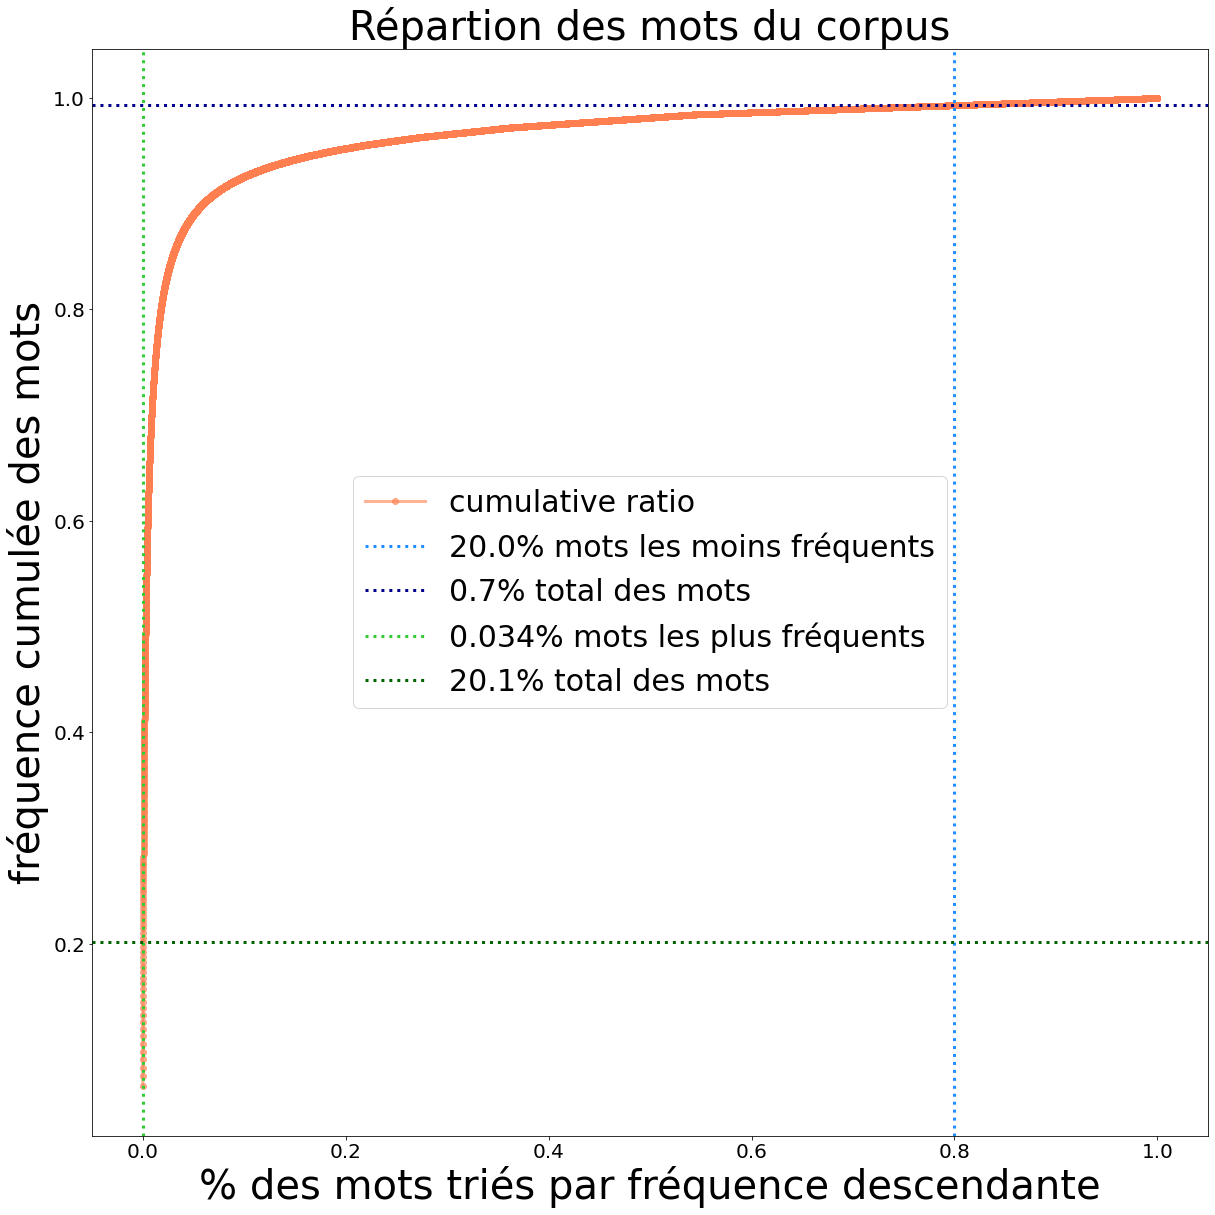

In [151]:
# Affichage du cumul des ratios de la variance expliquée
x = range(len(mot))
plt.figure(figsize=(20, 20))
plt.plot(perWordList, cumul, label='cumulative ratio', c='coral', linewidth=3, marker='o', alpha=0.6)
plt.axvline(x=k2, label="{0:.1f}% mots les moins fréquents".format((1-k2)*100),linestyle=':', color='dodgerblue', linewidth=3)
plt.axhline(y=k1, label="{0:.1f}% total des mots".format((1-k1)*100),linestyle=':', color='darkblue', linewidth=3)
plt.axvline(x=k4, label="{0:.3f}% mots les plus fréquents".format(k4*100),linestyle=':', color='limegreen', linewidth=3)
plt.axhline(y=k3, label="{0:.1f}% total des mots".format(k3*100),linestyle=':', color='darkgreen', linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("% des mots triés par fréquence descendante", fontsize=40)
plt.ylabel("fréquence cumulée des mots", fontsize=40)
plt.title("Répartion des mots du corpus", fontsize=40)
plt.legend(fontsize=30)
plt.show()

### Liste des Stop Words pour la colonne 'Body', on ajoute également ceux présents dans la librarie nltk.

In [162]:
# Stop words
sw = set()

# on ajoute les stopword definis dans nltk
nltksw = []
for word in nltk.corpus.stopwords.words('english'):
    nltksw.append(lemmatizer.lemmatize(word))
        
# on ajoute a notre set de stop words 
# ceux qui sont sepcifique a notre corpus
# et on vérifie que nos Tags n'apparaissent dans les 
# stopword       
lmot2 = mot[idx2: ]
for i, v in enumerate(lmot2):
    if v in dictTag.keys():
        lmot2.pop(i)

# On ajoute toutes les lettre a l'exception des lettre 'c' et 'r'
# au stop word
alpha = list('abdefghijklmnopqstuvwxyz')

# On met notre set de stop word a jour
sw.update(lmot1)
sw.update(lmot2)
sw.update(alpha)
sw.update(nltksw)
# On s'assure de ne pas tenir compte 
# des caractères spéciaux non filré
sw.update(['.', '#', '+', '-'])
sw

{'ideaprojects',
 'christmas-tree',
 'csam',
 'factorgroup',
 'looser',
 'adryesoptions',
 'customsearch',
 'newitemform',
 'oga',
 'endip',
 'appendminelementfortype',
 'foob',
 'sic',
 'add+',
 'inasmuch',
 'bosnaweb',
 'koala',
 'appcompatactionbar',
 'registerclassex',
 'cssobj',
 'fndropdownurl',
 'beantypetwo',
 'np-array',
 's.fk',
 'varvar',
 'insofar',
 '-db-nosql-mongo',
 "needn't",
 'excessrefinedkey',
 'invokemember',
 'addcontacts',
 'enterprisedb',
 'deselectall',
 'title.id',
 'placeholderfallback',
 'enterkey',
 'ultrastep.ru',
 'rigourous',
 'reprint',
 'your',
 'fws',
 'bs.a',
 'bigserial',
 'db-backup',
 'cmdoptions.py',
 'dintre',
 'producteditorcomponent',
 'hlfmvvw',
 'lngbox',
 'handlecommentedit',
 'instructionsview',
 'spring-core',
 'rbar',
 'somestaticmethod',
 'readxmpproperties',
 'xspf',
 'regocnise',
 'logadmin',
 'modelunittests',
 'lfr-panel-title',
 'christofer',
 'production-grade',
 'set.id',
 'transactios',
 'pearl',
 'zctboba',
 'apy',
 'relsz',
 '

# Enregistrements

In [163]:
with open("dataMultilabel", 'wb') as file:
    pickler = pck(file)
    pickler.dump(corpusTrain)
    pickler.dump(corpusTest)
    pickler.dump(y_train)
    pickler.dump(y_test)
    pickler.dump(Tag)
    pickler.dump(sw)

In [155]:
Tf = time.time()
print(Tf - Ti)

633.7254757881165
